In [1]:
import networkx as nx
import community
from community import community_louvain
import numpy as np
import copy  
import matplotlib.pyplot as plt
import collections
import graph_ase_BNU
from sklearn.utils.extmath import randomized_svd
import collections
from itertools import compress
import copy
import lcc_BNU
import pandas as pd
import seaborn as sns

In [2]:
def ase_graph(G): 
    sorted_vertex = sorted(G.nodes())
    A = nx.to_scipy_sparse_matrix(G, nodelist=sorted_vertex)
    n = G.number_of_nodes()
    max_dim = max_dim_ase
    
    svd_seed = 1234
    U, Sigma, VT = randomized_svd(A, 
                              n_components=min(max_dim, n - 1),
                              n_iter=50,
                              random_state=svd_seed)

    ##print ("dimension reduction (elbow selection)")
    #rank_graph =  getElbows_BNU.getElbows(Sigma, n_elbows=elb)
    
    #reduced_dim = rank_graph[(elb-1)]
    ##print ("elbow is %d" %reduced_dim)

    reduced_dim = 2 
    s_sqrt = np.sqrt(Sigma) 

    
    s_sqrt_dim_reduced = s_sqrt[:reduced_dim]
    U_dim_reduced = U[:, :reduced_dim ]
    VT_dim_reduced =VT[:reduced_dim, :]

    Xhat = np.multiply( s_sqrt_dim_reduced, U_dim_reduced)
    
    embedded_dict = {}
    for _, vertex in enumerate(sorted_vertex):
        embedded_dict[vertex] = Xhat[_, :]
     
    
    embedded = collections.namedtuple('embedded', 'Xhat vertex_labels dict')
    result = embedded(Xhat = Xhat, vertex_labels = sorted_vertex, dict = embedded_dict)
    
    return result

def sqdist(vector):
    return sum(x*x for x in vector)

def degtrim_max(G, max_threshold):
    tmpG = copy.deepcopy(G)

    for vertex in G.nodes():
        if G.degree[vertex] >= max_threshold:
            tmpG.remove_node(vertex)

    Graph = copy.deepcopy(tmpG)
    louvain = community.best_partition(Graph, resolution=1, randomize=False)
    mod = community.modularity(louvain, Graph)

    embedded = collections.namedtuple('embedded', 'G mod')
    result = embedded(G = Graph, mod = mod)

    return result

def degtrim_min(G, min_threshold):
    tmpG = copy.deepcopy(G)

    for vertex in G.nodes():
        if G.degree[vertex] <= min_threshold:
            tmpG.remove_node(vertex)

    Graph = copy.deepcopy(tmpG)
    louvain = community.best_partition(Graph, resolution=1, randomize=False)
    mod = community.modularity(louvain, Graph)

    embedded = collections.namedtuple('embedded', 'G mod')
    result = embedded(G = Graph, mod = mod)

    return result

def degtrim_minmax(G, percent_threshold):

    tmpG = copy.deepcopy(G)
    sorted_degrees_desc = sorted(G.degree, key=lambda x: x[1], reverse=True)
    sorted_degrees_asc = sorted(G.degree, key=lambda x: x[1], reverse=False)
    count_threshold = int(percent_threshold * G.number_of_nodes())
    ctr = 0 
    if ctr <= count_threshold:
        high_trim = sorted_degrees_desc[ctr][0]
        low_trim = sorted_degrees_asc[ctr][0]
        tmpG.remove_node(high_trim)
        tmpG.remove_node(low_trim)
        ctr += 1
        

    Graph = copy.deepcopy(tmpG)
    louvain = community.best_partition(Graph, resolution=1, randomize=False)
    mod = community.modularity(louvain, Graph)

    embedded = collections.namedtuple('embedded', 'G mod')
    result = embedded(G = Graph, mod = mod)

    return result

#procrustes
def procrustes(A, B):
    tmp = A.T @ B
    U_tmp, Sigma_tmp, VT_tmp = np.linalg.svd(tmp)
    W = U_tmp @ VT_tmp
    return W
    #A@W - B

In [3]:
file_108 = r'/Users/z/Desktop/execs_email_t108.txt'
file_109 = r'/Users/z/Desktop/execs_email_t109.txt'


In [4]:
G108 = nx.read_weighted_edgelist(file_108, comments='#', delimiter=' ', create_using=None, nodetype=str,  encoding='utf-8')
G109 = nx.read_weighted_edgelist(file_109, comments='#', delimiter=' ', create_using=None, nodetype=str,  encoding='utf-8')


In [5]:
print(G108.size())
print(G108.number_of_nodes())
print(G109.size())
print(G109.number_of_nodes())

136
88
166
98


In [6]:
Gworld =  G108
Gworld.add_nodes_from(G109)
world_n = Gworld.number_of_nodes()
world_sorted_vertex = sorted(Gworld.nodes())
print(world_n)

print(Gworld.number_of_edges())

106
136


In [7]:
pi_plus = 0.1
s_Wplus = np.random.binomial(n=1, p=pi_plus, size=world_n)
s_Wplus_bool = list(map(bool,s_Wplus))
Wplus = sorted(list(compress(world_sorted_vertex, s_Wplus_bool)))

pi_minus = 0.1
s_Wminus = np.random.binomial(n=1, p=pi_minus, size=world_n)
s_Wminus_bool = list(map(bool,s_Wminus))
Wminus0 = list(compress(world_sorted_vertex, s_Wminus_bool))
#del any Wminus that is in Wplus:
Wminus = sorted(list(set(Wminus0) - set(Wplus)))


# print(Wplus)
# print(Wminus0)
# print(Wminus)


In [120]:
Vplus_candidate = list(set(world_sorted_vertex) - set(Wminus))
Vminus_candidate = list(set(world_sorted_vertex) - set(Wplus))

Gnoise = copy.deepcopy(Gworld)
p_plus = 0.3
for vertex in Wplus:
    for target in Vplus_candidate:
        s = np.random.binomial(n=1, p=p_plus, size=1)
        if s ==1 :
            if vertex != target:
                Gnoise.add_edge(vertex, target) 
    
print(Gnoise.number_of_nodes())
print(Gnoise.number_of_edges())

p_minus = 0.3
for vertex in Wminus:
    for target in Vminus_candidate:
        s = np.random.binomial(n=1, p=p_minus, size=1)
        if s ==1 :
            if Gnoise.has_edge(vertex, target):
                Gnoise.remove_edge(vertex, target) 
                
print(Gnoise.number_of_nodes())
print(Gnoise.number_of_edges())

106
361
106
356


In [121]:
Graph = copy.deepcopy(G108)
louvain_G108 = community.best_partition(Graph, resolution=1, randomize=False)
mod_G108 = community.modularity(louvain_G108, Graph)
print(mod_G108)

0.7797091262975778


In [122]:
#0.14 with p=0.8 works we have Q= 0.14
#for p=0.5 we have Q = 0.26
#for p=0.3 we have Q = 0.34
Graph = copy.deepcopy(Gnoise)
louvain_Gnoise = community.best_partition(Graph, resolution=1, randomize=False)
mod_Gnoise = community.modularity(louvain_Gnoise, Graph)
print(mod_Gnoise)

0.3489182237091277


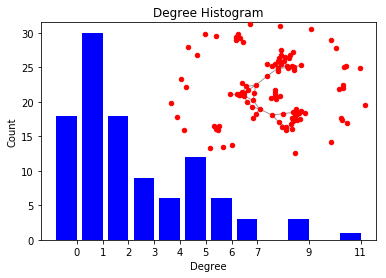

In [127]:
# G = G108

# degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
# # print "Degree sequence", degree_sequence
# degreeCount = collections.Counter(degree_sequence)
# deg, cnt = zip(*degreeCount.items())

# fig, ax = plt.subplots()
# plt.bar(deg, cnt, width=0.80, color='b')

# plt.title("Degree Histogram")
# plt.ylabel("Count")
# plt.xlabel("Degree")
# ax.set_xticks([d + 0.4 for d in deg])
# ax.set_xticklabels(deg)

# # draw graph in inset
# plt.axes([0.4, 0.4, 0.5, 0.5])
# Gcc = sorted(nx.connected_component_subgraphs(G), key=len, reverse=True)[0]
# pos = nx.spring_layout(G)
# plt.axis('off')
# nx.draw_networkx_nodes(G, pos, node_size=20)
# nx.draw_networkx_edges(G, pos, alpha=0.4)

# plt.show()

# deg_G108 = deg

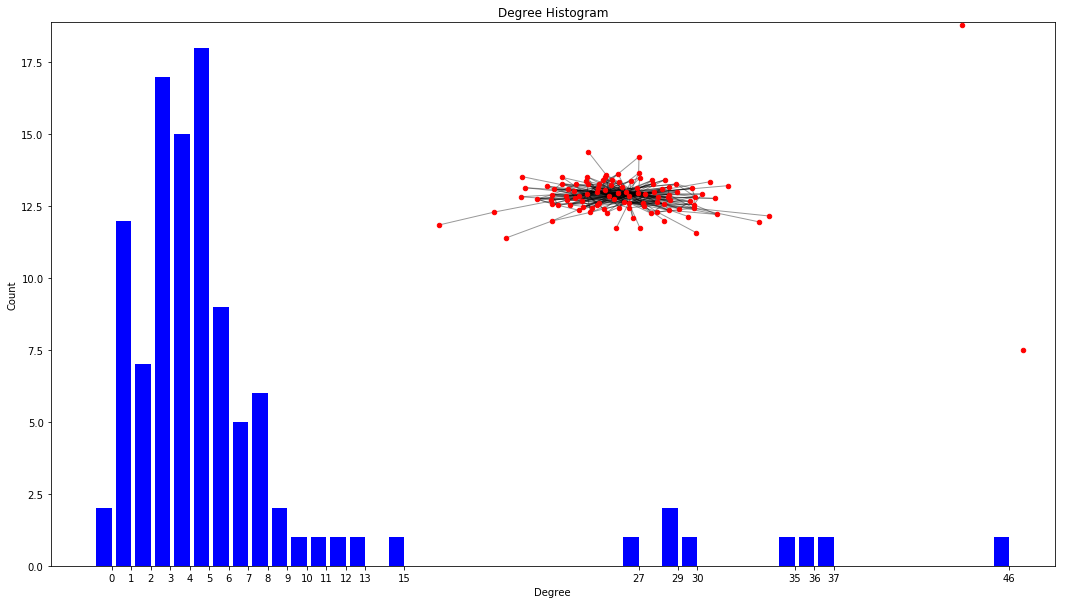

In [128]:
G = Gnoise

degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
# print "Degree sequence", degree_sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

fig, ax = plt.subplots(figsize=(18,10))
plt.bar(deg, cnt, width=0.80, color='b')

plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")
ax.set_xticks([d + 0.4 for d in deg])
ax.set_xticklabels(deg)

# draw graph in inset
plt.axes([0.4, 0.4, 0.5, 0.5])
Gcc = sorted(nx.connected_component_subgraphs(G), key=len, reverse=True)[0]
pos = nx.spring_layout(G)
plt.axis('off')
nx.draw_networkx_nodes(G, pos, node_size=20)
nx.draw_networkx_edges(G, pos, alpha=0.4)

plt.show()

#deg_Gnoise = deg

In [61]:
# print(deg_Gnoise)
# print(deg_G108)


(86, 82, 81, 80, 79, 78, 76, 75, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 3, 2, 0)
(11, 9, 7, 6, 5, 4, 3, 2, 1, 0)


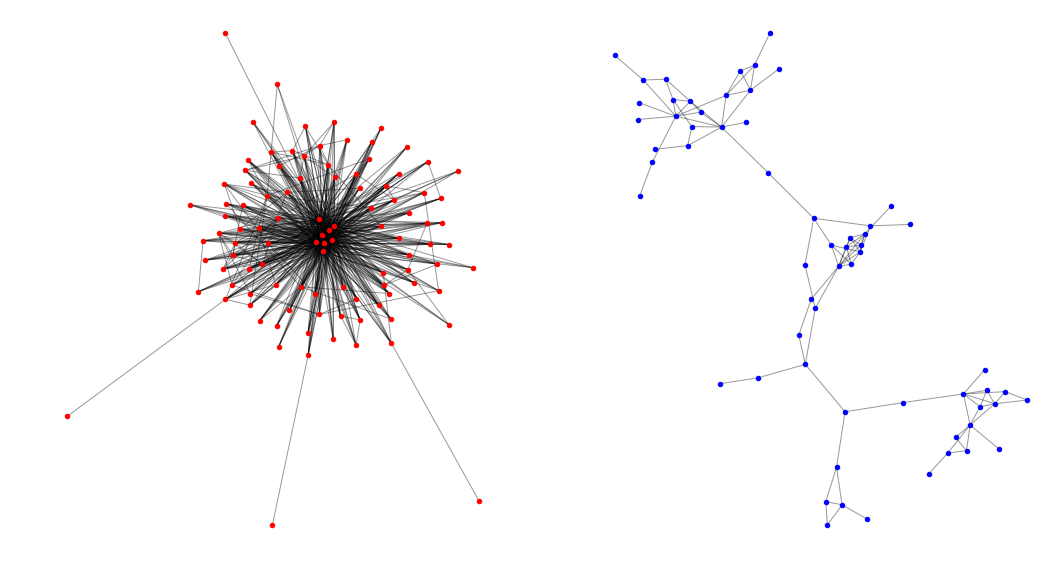

In [13]:
G = lcc_BNU.extract_lcc(Gnoise)

fig, ax = plt.subplots(figsize=(18,10))

plt.title("Gnoise_lcc")

plt.subplot(1, 2, 1)

Gcc = sorted(nx.connected_component_subgraphs(G), key=len, reverse=True)[0]
pos = nx.spring_layout(G)
plt.axis('off')
nx.draw_networkx_nodes(G, pos, node_size=20)
nx.draw_networkx_edges(G, pos, alpha=0.4)

plt.subplot(1, 2, 2)
G2 = lcc_BNU.extract_lcc(G108)

Gcc = sorted(nx.connected_component_subgraphs(G2), key=len, reverse=True)[0]
pos = nx.spring_layout(G2)
plt.axis('off')
nx.draw_networkx_nodes(G2, pos, node_size=20, node_color='blue')
nx.draw_networkx_edges(G2, pos, alpha=0.4)

plt.show()

In [115]:
# graphs_modularity1 = []
# graphs_maxdeg = []
# max_deg_list = deg_Gnoise[0:10]

# G_trimmed_new = Gnoise
# for max_deg in max_deg_list:
#     Gtrim_mod = degtrim_max(G_trimmed_new, max_deg)
#     G_trimmed_new = Gtrim_mod.G
#     graphs_maxdeg.append(max_deg)
#     graphs_modularity1.append(Gtrim_mod.mod) 
# G_trim_high = G_trimmed_new

# print (graphs_modularity1)
# print (graphs_maxdeg)

[0.10515646558720881, 0.10515646558720881, 0.11161782973946985, 0.11161782973946985, 0.14046508875739647, 0.14046508875739647, 0.15143440453686202, 0.15143440453686202, 0.8091535965386698, 0.8091535965386698]
[86, 82, 81, 80, 79, 78, 76, 75, 16, 15]


[Text(0, 0, '7'),
 Text(0, 0, '6'),
 Text(0, 0, '5'),
 Text(0, 0, '4'),
 Text(0, 0, '3'),
 Text(0, 0, '2'),
 Text(0, 0, '1'),
 Text(0, 0, '0')]

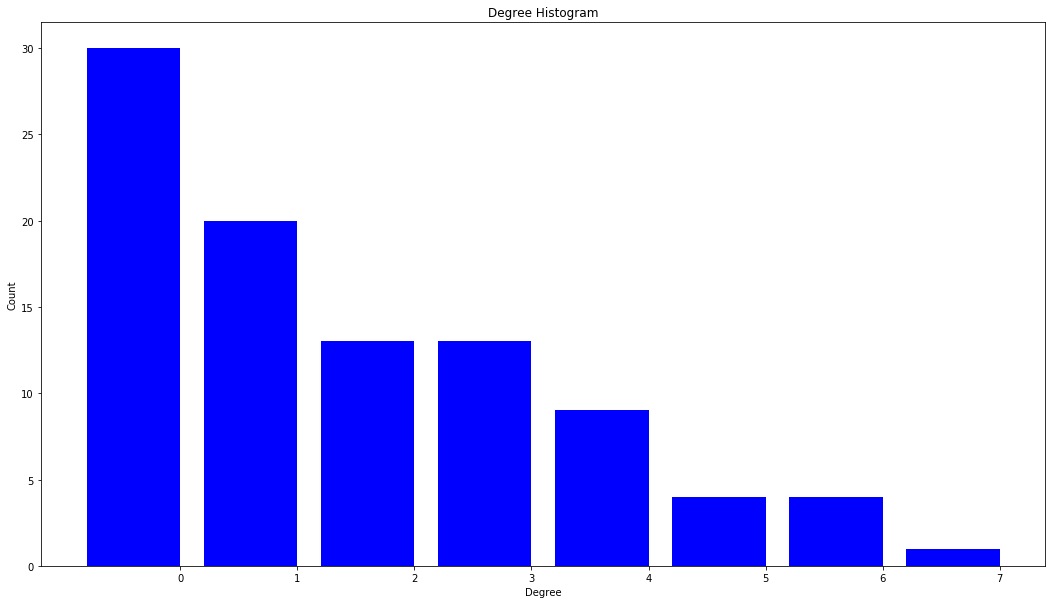

In [117]:
# G = G_trim_high

# degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
# # print "Degree sequence", degree_sequence
# degreeCount = collections.Counter(degree_sequence)
# deg, cnt = zip(*degreeCount.items())

# fig, ax = plt.subplots(figsize=(18,10))
# plt.bar(deg, cnt, width=0.80, color='b')

# plt.title("Degree Histogram")
# plt.ylabel("Count")
# plt.xlabel("Degree")
# ax.set_xticks([d + 0.4 for d in deg])
# ax.set_xticklabels(deg)

In [82]:
#sorted(min_deg_list)

[0, 2, 3, 6, 7, 8]

In [ ]:
# max_deg = 9
# Gtrim_mod = degtrim_max(G_109, max_deg)
# G109_trimmed = Gtrim_mod.G
# mod_109_trimmed = Gtrim_mod.mod
# print (mod_109_trimmed)

In [14]:
# degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
# # print "Degree sequence", degree_sequence
# degreeCount = collections.Counter(degree_sequence)
# deg, cnt = zip(*degreeCount.items())

# fig, ax = plt.subplots(figsize=(18,10))
# plt.bar(deg, cnt, width=0.80, color='b')

# plt.title("Degree Histogram")
# plt.ylabel("Count")
# plt.xlabel("Degree")
# ax.set_xticks([d + 0.4 for d in deg])
# ax.set_xticklabels(deg)

# deg

In [95]:
# graphs_modularity2 = []
# graphs_mindeg = []
# min_deg_list = sorted(deg_Gnoise[-12:])
# print(min_deg_list)

# #G_trimmed_new = G_trim_high
# G_trimmed_new = Gnoise

# for min_deg in min_deg_list:
#     Gtrim_mod = degtrim_min(G_trimmed_new, min_deg)
#     G_trimmed_new = Gtrim_mod.G
#     graphs_mindeg.append(min_deg)
#     graphs_modularity2.append(Gtrim_mod.mod) 

# print (graphs_modularity2)
# print (graphs_mindeg)


[0, 2, 3, 6, 7, 8, 9, 10, 11, 12, 13, 14]
[0.09856622116783156, 0.09576382831661806, 0.09154685818877015, 0.09283257378472225, 0.09228032450174148, 0.09141548180658246, 0.08807306885663115, 0.0927847800237812, 0.10036493366774688, 0.0906356807257708, 0.054953954370864005, 0.03145087235996316]
[0, 2, 3, 6, 7, 8, 9, 10, 11, 12, 13, 14]


In [15]:
# graphs_modularity3 = []

# percent_threshold = [0.01, 0.02, 0.05, 0.08, 0.1, 0.13, 0.16, 0.2, 0.25, 0.3, 0.35]

# G_trimmed_new = Gnoise
# for percent in percent_threshold :
#     Gtrim_mod = degtrim_minmax(G_trimmed_new, percent)
#     G_trimmed_new = Gtrim_mod.G
#     graphs_modularity3.append(Gtrim_mod.mod) 
# G_trim = G_trimmed_new

# print (graphs_modularity3)

# #print(G_trim.nodes())

# degree_sequence = sorted([d for n, d in G_trim.degree()], reverse=True)  # degree sequence
# # print "Degree sequence", degree_sequence
# degreeCount = collections.Counter(degree_sequence)
# deg, cnt = zip(*degreeCount.items())

# fig, ax = plt.subplots(figsize=(18,10))
# plt.bar(deg, cnt, width=0.80, color='b')

# plt.title("Degree Histogram before breakthrough")
# plt.ylabel("Count")
# plt.xlabel("Degree")
# ax.set_xticks([d + 0.4 for d in deg])
# ax.set_xticklabels(deg)



[0.3866024973985432, 0.42017422345356703, 0.4589409722222222, 0.5176127958579883, 0.5689585218938235, 0.6404735110803325, 0.7205034410068819, 0.8125170068027212, 0.8235457063711912, 0.8416838842975205, 0.8776101204084744]


[Text(0, 0, '6'),
 Text(0, 0, '5'),
 Text(0, 0, '4'),
 Text(0, 0, '3'),
 Text(0, 0, '2'),
 Text(0, 0, '1'),
 Text(0, 0, '0')]

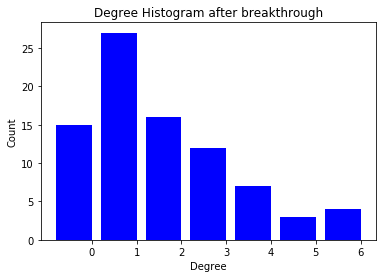

In [183]:
graphs_modularity3 = []

#percent_threshold = [0.01, 0.02, 0.05, 0.08, 0.1, 0.13, 0.16, 0.2, 0.25, 0.3, 0.35, 0.4] #this was for 108

percent_threshold = [0.01, 0.02, 0.05, 0.08, 0.1, 0.13, 0.16, 0.17, 0.2, 0.25, 0.3] #, 0.35]#, 0.4] 
                     
G_trimmed_new = Gnoise
for percent in percent_threshold :
    Gtrim_mod = degtrim_minmax(G_trimmed_new, percent)
    G_trimmed_new = Gtrim_mod.G
    graphs_modularity3.append(Gtrim_mod.mod) 
Gtrim = G_trimmed_new

print (graphs_modularity3)

#print(G_trim.nodes())

degree_sequence = sorted([d for n, d in Gtrim.degree()], reverse=True)  # degree sequence
# print "Degree sequence", degree_sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

fig, ax = plt.subplots()
plt.bar(deg, cnt, width=0.80, color='b')

plt.title("Degree Histogram after breakthrough")
plt.ylabel("Count")
plt.xlabel("Degree")
ax.set_xticks([d + 0.4 for d in deg])
ax.set_xticklabels(deg)


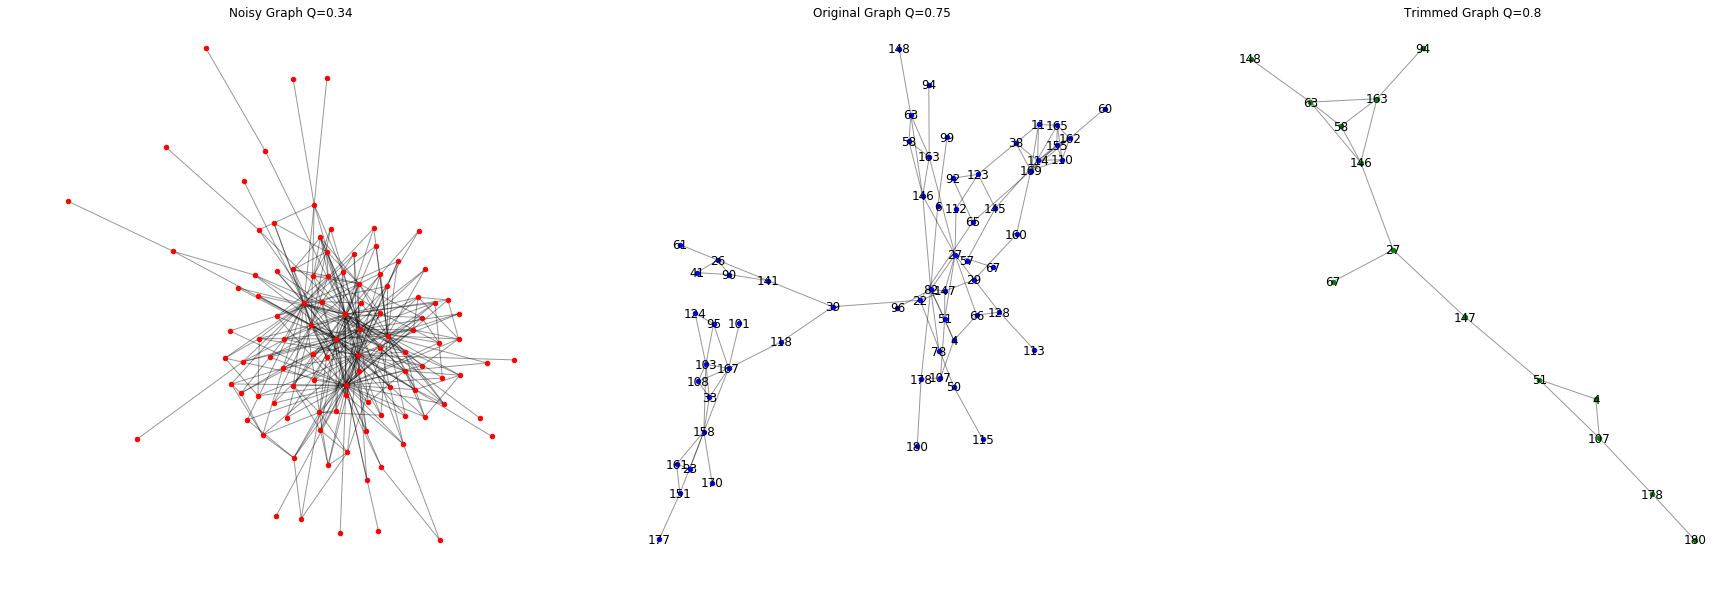

In [209]:
G = lcc_BNU.extract_lcc(Gnoise)

fig, ax = plt.subplots(figsize=(30,10))


plt.subplot(1, 3, 1)
plt.title("Noisy Graph Q=0.34")

Gcc = sorted(nx.connected_component_subgraphs(G), key=len, reverse=True)[0]
pos = nx.spring_layout(G)
plt.axis('off')
nx.draw_networkx_nodes(G, pos, node_size=20)
nx.draw_networkx_edges(G, pos, alpha=0.4)

plt.subplot(1, 3, 2)
plt.title("Original Graph Q=0.75")
G2 = lcc_BNU.extract_lcc(G108)

Gcc = sorted(nx.connected_component_subgraphs(G2), key=len, reverse=True)[0]
pos = nx.spring_layout(G2)
plt.axis('off')
nx.draw_networkx_nodes(G2, pos, node_size=20, node_color='blue')
nx.draw_networkx_edges(G2, pos, alpha=0.4)
nx.draw_networkx_labels(G2, pos)

plt.subplot(1, 3, 3)
plt.title("Trimmed Graph Q=0.8")
G3 = lcc_BNU.extract_lcc(Gtrim)
Gcc = sorted(nx.connected_component_subgraphs(G3), key=len, reverse=True)[0]
pos = nx.spring_layout(G3)
plt.axis('off')
nx.draw_networkx_nodes(G3, pos, node_size=20, node_color = 'green',  with_labels = True)
nx.draw_networkx_edges(G3, pos, alpha=0.4)
nx.draw_networkx_labels(G3, pos)

plt.show()



In [195]:
print(set(Gnoise.nodes()) - set(Gtrim.nodes()))
#note here trimming only trimmed nodes that were common in both G108 and G109
#remember to do procrustes!!!!! 

intersecting_108_noise =   set(G108.nodes()).intersection(set(Gnoise.nodes()))
intersecting_all3 =   list(set(intersecting_108_noise).intersection(set(Gtrim.nodes())))

print(len(intersecting_108_noise))
print(len(intersecting_all3))

{'57', '156', '161', '23', '169', '82', '66', '139', '157', '170', '176', '96', '62', '99', '113', '11', '81', '39', '158', '6', '114', '128'}
106
84


In [196]:
max_dim_ase = 2

ase_G108 = ase_graph(G108)
ase_Gnoise = ase_graph(Gnoise)
ase_Gtrim = ase_graph(Gtrim)


In [197]:

intersecting_index = []
for v in intersecting_all3:
    intersecting_index.append(ase_G108.vertex_labels.index(v))
Xhat108_shared = ase_G108.Xhat[intersecting_index]

intersecting_index = []
for v in intersecting_all3:
    intersecting_index.append(ase_Gnoise.vertex_labels.index(v))
XhatNoise_shared = ase_Gnoise.Xhat[intersecting_index]

intersecting_index = []
for v in intersecting_all3:
    intersecting_index.append(ase_Gtrim.vertex_labels.index(v))
XhatTrim_shared = ase_Gtrim.Xhat[intersecting_index]

In [198]:
#procrustes
W_Noise_108 = procrustes(XhatNoise_shared, Xhat108_shared)
XhatNoise_shared_proj = XhatNoise_shared@W_Noise_108 


W_Trim_108 = procrustes(XhatTrim_shared, Xhat108_shared)
XhatTrim_shared_proj = XhatTrim_shared@W_Trim_108 


In [199]:

Xhat_108_Noise = Xhat108_shared - XhatNoise_shared_proj 
diff_108_Noise = np.linalg.norm(Xhat_108_Noise, axis=1)

In [200]:
#XhatTrim_shared_proj [:,0]

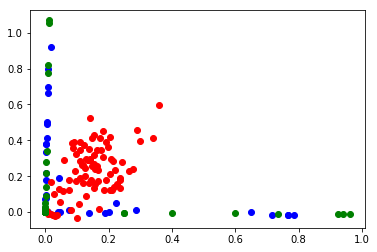

In [201]:
Xhat_108_Noise = Xhat108_shared - XhatNoise_shared_proj 


plt.plot(Xhat108_shared[:,0], Xhat108_shared[:,1], 'bo')
plt.plot(XhatNoise_shared_proj [:,0], XhatNoise_shared_proj [:,1], 'ro')
plt.plot(XhatTrim_shared_proj [:,0], XhatTrim_shared_proj [:,1], 'go')


In [176]:
#diff_108_Noise

In [202]:
Xhat_108_Trim = Xhat108_shared - XhatTrim_shared_proj 
diff_108_Trim = np.linalg.norm(Xhat_108_Trim, axis=1)
#diff_108_Trim

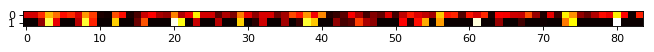

In [203]:
a = np.array(diff_108_Noise)
b = np.array(diff_108_Trim)
m = np.vstack((a,b))
#m1 = np.asmatrix(m)
plt.figure(figsize=(10, 10), dpi=80)
plt.imshow(m, cmap='hot', interpolation='nearest')
plt.show()
#black means small number

(array([ 9.,  9.,  6., 10., 19., 13.,  5.,  6.,  1.,  2.]),
 array([0.00681912, 0.07700507, 0.14719103, 0.21737698, 0.28756294,
        0.3577489 , 0.42793485, 0.49812081, 0.56830677, 0.63849272,
        0.70867868]),
 <a list of 10 Patch objects>)

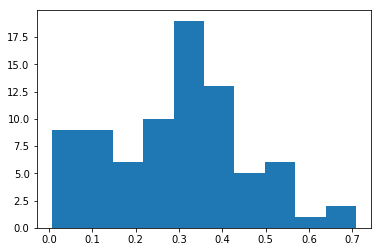

In [179]:
plt.hist(a)

(array([53.,  6.,  5.,  2.,  4.,  2.,  2.,  3.,  0.,  3.]),
 array([0.        , 0.09406504, 0.18813008, 0.28219512, 0.37626015,
        0.47032519, 0.56439023, 0.65845527, 0.75252031, 0.84658535,
        0.94065039]),
 <a list of 10 Patch objects>)

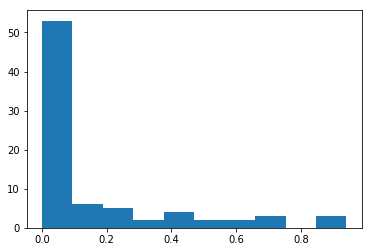

In [180]:
plt.hist(b)

In [31]:
#diff_108_Noise

array([0.44589426, 0.45530303, 0.5378298 , 0.50277347, 0.39926893,
       0.50718951, 0.36359808, 0.45882371, 0.53325563, 0.59831867,
       0.45360656, 0.46701443, 0.3782659 , 0.44203991, 0.44992586,
       0.36343336, 0.22680399, 0.45238606, 0.45286787, 0.44613817,
       0.60120389, 0.52062167, 0.63287144, 0.51916647, 0.59439087,
       0.53108119, 0.3797852 , 0.4472712 , 0.44510019, 0.52942799,
       0.56420037, 0.31288794, 0.29857178, 0.59868645, 0.45128325,
       0.52560144, 0.54157405, 0.43893963, 0.59814384, 0.02559308,
       0.36303562, 0.39640187, 0.45433665, 0.4472712 , 0.36341411,
       0.25983841, 0.60048243, 0.43106196, 0.52489634, 0.52236624,
       0.44406143, 0.4254665 , 0.52139056, 0.56664796, 0.42706242,
       0.44858525, 0.51984672, 0.51370237, 0.60048243, 0.45466823,
       0.38156238, 0.45466823, 0.20326558, 0.59611238, 0.29787156,
       0.60048243, 0.25002478, 0.524605  , 0.51916647, 0.3661367 ,
       0.28910429, 0.45648146, 0.68319719, 0.5003565 , 0.60048

In [204]:
rank_trim = []
rank_noise = []

idx = 1 

for idx in range(Xhat108_shared.shape[0]):
    distance_to_noisy = XhatNoise_shared_proj - Xhat108_shared[idx,]
    diff_Noise_108v = np.linalg.norm(distance_to_noisy, axis=1)
    distance_to_trim = XhatTrim_shared_proj - Xhat108_shared[idx,]
    diff_Trim_108v = np.linalg.norm(distance_to_trim, axis=1)
    rank_trim.append(diff_Trim_108v.argsort()[0]) 
    rank_noise.append(diff_Noise_108v.argsort()[0])


delta_rank = np.array(rank_noise) - np.array(rank_trim)

In [112]:
# print(rank_noise)
# print(rank_trim)

[50, 50, 1, 3, 60, 50, 50, 50, 3, 50, 50, 50, 2, 50, 50, 0, 60, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 3, 50, 71, 52, 50, 50, 1, 50, 3, 15, 50, 10, 10, 1, 15, 75, 50, 59, 50, 50, 15, 71, 50, 15, 50, 50, 2, 50, 50, 50, 50, 50, 50, 37, 50, 50, 50, 69, 50, 50, 50, 50, 50, 77, 3, 50, 50, 50, 50, 50, 50, 50]
[62, 79, 61, 36, 16, 62, 10, 5, 36, 5, 62, 46, 71, 79, 62, 68, 51, 62, 79, 5, 5, 5, 75, 10, 79, 5, 5, 79, 36, 79, 45, 15, 79, 62, 61, 5, 36, 51, 5, 40, 31, 65, 43, 15, 79, 15, 79, 46, 43, 45, 79, 43, 5, 62, 12, 5, 79, 63, 62, 5, 62, 15, 63, 79, 79, 30, 5, 10, 5, 79, 79, 54, 36, 11, 79, 5, 79, 5, 63, 79]


In [210]:
print(rank_noise)
print(rank_trim)

[82, 82, 59, 5, 58, 82, 82, 82, 46, 82, 82, 82, 40, 82, 82, 4, 58, 82, 82, 82, 82, 82, 82, 40, 82, 82, 82, 82, 82, 46, 82, 70, 4, 82, 82, 28, 82, 59, 46, 83, 82, 82, 75, 28, 59, 33, 4, 4, 82, 82, 82, 83, 70, 83, 82, 82, 40, 82, 82, 82, 82, 82, 82, 82, 4, 82, 82, 50, 82, 82, 82, 82, 82, 40, 46, 82, 82, 82, 82, 82, 82, 82, 82, 82]
[82, 83, 43, 21, 56, 82, 82, 24, 21, 24, 82, 81, 45, 83, 82, 26, 56, 82, 83, 24, 24, 24, 31, 45, 82, 83, 24, 24, 83, 54, 83, 69, 26, 83, 82, 44, 24, 43, 21, 56, 24, 83, 44, 44, 43, 56, 26, 26, 83, 83, 81, 56, 6, 56, 24, 82, 4, 24, 83, 41, 82, 24, 82, 82, 26, 25, 83, 53, 24, 82, 24, 83, 83, 45, 21, 59, 83, 24, 83, 24, 24, 83, 25, 83]


In [113]:
# diff_Noise_108v.argsort()

array([50, 22, 11, 71, 78, 24,  1, 69, 64, 45, 76, 33,  9, 17,  0, 12, 14,
       59, 27, 79, 29,  7, 41, 10, 42, 37, 40, 74, 25, 70, 18,  6, 73,  5,
       48, 57, 61, 63, 68, 13, 52, 75, 23, 32, 36, 62, 65, 54,  3, 58, 43,
        4, 72, 39, 30, 21, 26, 53, 49, 56, 44, 66, 15, 19, 38, 67, 34, 35,
       20, 60, 55, 77, 46, 47,  8, 51, 28, 16, 31,  2])

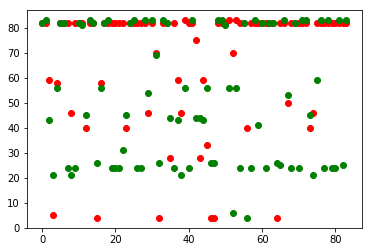

In [205]:
plt.plot(np.array(rank_noise), 'ro')
plt.plot(np.array(rank_trim), 'go')


In [33]:
#delta_rank_original = np.array([  2,  51,  51,  44,  25,  51, -26,  21,  51,  27,  51,  51,  -1,
       -13, -30,  27, -13,  51,  25,  34, -29, -37,  34,   4, -20,  34,
        44,  33, -29,  51,  33, -24,  51,  -4, -46,  51, -29,  25,   4,
        33,  -4, -20,  51,  51,  -4, -12,  34,  25,  -1, -24,  -1,  34,
        45,  -1,  -1,   8,  27,  51,  51, -10, -13, -57, -29,  51,  -8,
        14, -24,  33,  27, -55,  27])

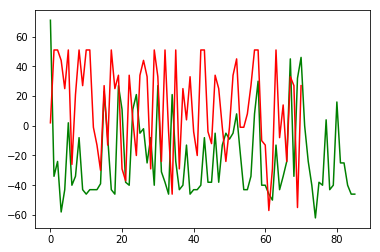

In [34]:
#plt.plot(delta_rank, 'g')
#plt.plot(delta_rank_original, 'r')

In [35]:
#delta_rank

array([ 71, -34, -24, -58, -43,   2, -40, -34,  -8, -43, -46, -43, -43,
       -43, -39,  23,  -8, -43, -46,  27,  11, -38, -40,  11,  21,  -5,
        -2, -25,  -8, -40,  27, -31, -38, -46,  21, -24, -43, -40, -13,
       -46, -43, -43, -40,  -8, -38, -38,  -5, -38, -13,  -5,  -9,  -5,
         8, -18, -43, -43, -34,   8,  30, -40, -40, -46, -50, -13, -43,
       -34, -24,  45, -34,  32,  46,   0, -24, -40, -62, -38, -40,   4,
       -43, -40,  16, -25, -25, -40, -46, -46])

In [36]:
delta_rank_sign = delta_rank
delta_rank_sign[delta_rank_sign < 0] = 0
delta_rank_sign[delta_rank_sign > 0] = 1

In [37]:
delta_rank_sign

array([1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0])

In [38]:
delta_rank_original_sign = delta_rank_original
delta_rank_original_sign[delta_rank_original_sign < 0] = 0
delta_rank_original_sign[delta_rank_original_sign > 0] = 1

In [39]:
delta_rank_original_sign

array([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1,
       0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1,
       0, 1, 1, 0, 1])

In [40]:
df_artificial =  pd.DataFrame(columns = ['rank_delta', 'Type'])
df_artificial['rank_delta'] = delta_rank
df_artificial['Type'] = np.repeat('Artificial', len(delta_rank))

df_original = pd.DataFrame(columns = ['rank_delta', 'Type'])
df_original['rank_delta'] = delta_rank_original
df_original['Type'] = np.repeat('Observed', len(delta_rank_original))


df_rank = df_artificial.append(df_original, ignore_index=True)

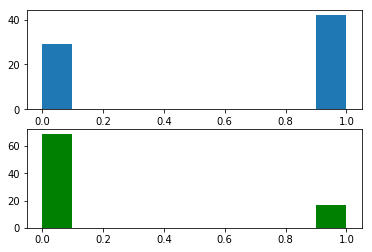

In [41]:
# Iterate through the five airlines

plt.subplot(2, 1, 1)
for i in ['Observed']: #, 'Artificial']:
    
    # Subset to the airline
    data =   delta_rank_original#(df_rank.loc[df_rank['Type'] == i])
    # Draw the density plot
    plt.hist(data) #, label = i)

    
plt.subplot(2, 1, 2)    
# Iterate through the five airlines
for i in ['Artificial']: #, 'Artificial']:
    
    # Subset to the airline
    data =   delta_rank#(df_rank.loc[df_rank['Type'] == i])
    # Draw the density plot
    plt.hist(data, color='green') #, label = i)    

TypeError: unsupported operand type(s) for +: 'int' and 'str'

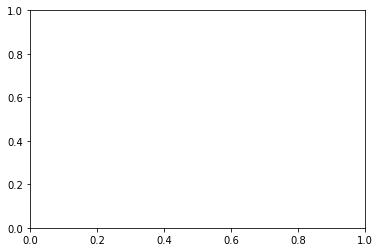

In [277]:
#wsign test p-value 



# Iterate through the five airlines
for i in ['Observed', 'Artificial']:
    # Subset to the airline
    data = (df_rank.loc[df_rank['Type'] == i])
    # Draw the density plot
    sns.distplot(data, hist = False, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = i)
    
# Plot formatting
plt.legend(prop={'size': 16}, title = 'Airline')
plt.title('Density Plot with Multiple Airlines')
plt.xlabel('Delay (min)')
plt.ylabel('Density')